## 1. 이미지에서 텍스트 추출하기(easyOCR)

In [2]:
import easyocr
import numpy as np
import cv2
from typing import List, Dict

In [58]:
reader = easyocr.Reader(['en'])
# result = reader.readtext("./test1.png")
result = reader.readtext("./test1.png", paragraph=True)
# result = reader.readtext('/test_image/테스트 이미지2(영문).png')
# result = reader.readtext('/test_image/테스트.jpg')
# result = reader.readtext('/test_image/테스트2.jpg')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [59]:
print(result)

[[[[7, 14], [697, 14], [697, 433], [7, 433]], 'It was the best of times, it was the worst of times, it was the age of wisdom; it was the age of foolishness .']]


In [28]:
OCR_RESULTS = []
print("✅ Result : ")
for res in result:
    OCR_RESULTS.append(res[0:2])
    print(res[0:2])

print(OCR_RESULTS)

✅ Result : 
([[12, 14], [540, 14], [540, 87], [12, 87]], 'It was the best of')
([[7, 99], [686, 99], [686, 178], [7, 178]], 'times, it was the worst')
([[11, 181], [697, 181], [697, 267], [11, 267]], 'of times, it was the age')
([[11, 256], [649, 256], [649, 345], [11, 345]], 'of wisdom; it was the')
([[7, 344], [563, 344], [563, 433], [7, 433]], 'age of foolishness .')
[([[12, 14], [540, 14], [540, 87], [12, 87]], 'It was the best of'), ([[7, 99], [686, 99], [686, 178], [7, 178]], 'times, it was the worst'), ([[11, 181], [697, 181], [697, 267], [11, 267]], 'of times, it was the age'), ([[11, 256], [649, 256], [649, 345], [11, 345]], 'of wisdom; it was the'), ([[7, 344], [563, 344], [563, 433], [7, 433]], 'age of foolishness .')]


## 2. 추출된 텍스트 번역
- 추출된 각 텍스트 영역에서 문맥상 이어지면 전체 문장을 고려하여 번역을 수행하고 다시 각 영역에 적절하게 번역된 텍스트 분배

In [9]:
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOpenAI

In [16]:
source_lang = "en"
target_lang = "ko"

In [37]:
prompt_text = open("../../prompts/OCR_translate.yaml", "r", encoding="utf-8").read()
prompt = PromptTemplate(
        template=prompt_text,
        input_variables=["OCR_RESULTS","source_lang","target_lang"]
    )

llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)
chain = prompt | llm

llm_result = chain.invoke({
    "OCR_RESULTS": OCR_RESULTS,
    "source_lang": source_lang,
    "target_lang": target_lang}
    )

In [44]:
import ast

# 문자열을 Python 객체로 변환
translated_results = ast.literal_eval(llm_result.content)

for index, result in enumerate(translated_results):
    print(result)


([[12, 14], [540, 14], [540, 87], [12, 87]], '그것은 최고의 시기였다')
([[7, 99], [686, 99], [686, 178], [7, 178]], '그것은 최악의 시기였다')
([[11, 181], [697, 181], [697, 267], [11, 267]], '그것은 지혜의 시대였다')
([[11, 256], [649, 256], [649, 345], [11, 345]], '그것은 어리석음의 시대였다')


## 3. 번역된 텍스트 융합 (fusing translated-text into the image)

In [ ]:
! pip install Pillow opencv-python numpy

[([[12, 14], [540, 14], [540, 87], [12, 87]], '그것은 최고의 시기였다'), ([[7, 99], [686, 99], [686, 178], [7, 178]], '그것은 최악의 시기였다'), ([[11, 181], [697, 181], [697, 267], [11, 267]], '그것은 지혜의 시대였다'), ([[11, 256], [649, 256], [649, 345], [11, 345]], '그것은 어리석음의 시대였다')]


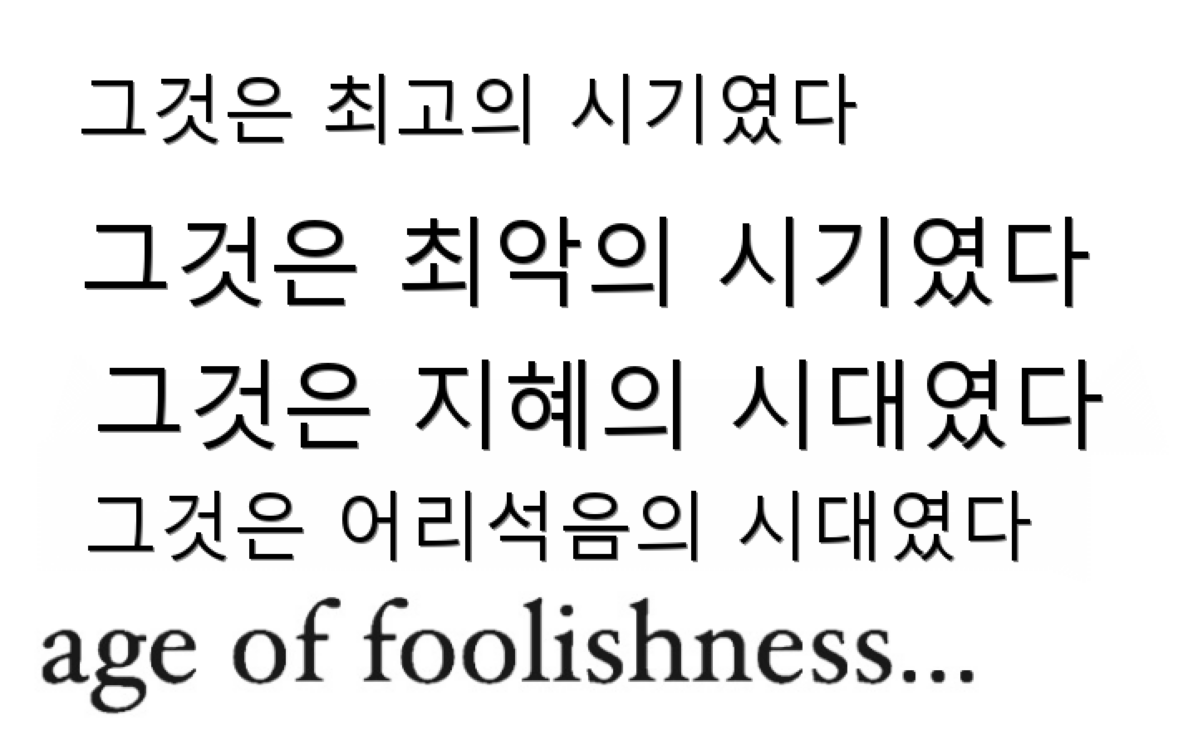

In [57]:
import cv2
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import ast

def fit_text_to_box(text, box_width, box_height, initial_font_size=100):
    """박스 크기에 맞게 폰트 크기를 조절하는 함수"""
    font_size = initial_font_size
    font = ImageFont.truetype("malgun.ttf", font_size)  # 한글 폰트 필요
    
    while font_size > 1:
        font = ImageFont.truetype("malgun.ttf", font_size)
        text_bbox = font.getbbox(text)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        # 여백을 고려하여 약간 작은 크기로 조정 (90%만 사용)
        if text_width <= box_width * 0.9 and text_height <= box_height * 0.9:
            break
            
        font_size -= 1
    
    return font, font_size

def remove_text(image, bbox, margin=2):
    """텍스트 영역을 주변 색상으로 채우는 함수"""
    # 바운딩 박스 좌표
    x_coords = [p[0] for p in bbox]
    y_coords = [p[1] for p in bbox]
    x1, y1 = min(x_coords), min(y_coords)
    x2, y2 = max(x_coords), max(y_coords)
    
    # 마스크 생성
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    pts = np.array(bbox, np.int32)
    cv2.fillPoly(mask, [pts], 255)
    
    # 텍스트 영역 주변의 색상으로 채우기
    return cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)


def add_translated_text(image_path, translated_results):
    # 이미지 로드
    image = cv2.imread(image_path)
    
    # 각 번역 결과에 대해 처리
    for bbox, translated_text in translated_results:
        # 원본 텍스트 제거
        image = remove_text(image, bbox)
    
    # OpenCV 이미지를 PIL 이미지로 변환
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(image_pil)
    
    # 번역된 텍스트 추가
    for bbox, translated_text in translated_results:
        # 박스 크기 계산
        x_coords = [p[0] for p in bbox]
        y_coords = [p[1] for p in bbox]
        box_width = max(x_coords) - min(x_coords)
        box_height = max(y_coords) - min(y_coords)
        
        # 텍스트 크기에 맞는 폰트 찾기
        font, font_size = fit_text_to_box(translated_text, box_width, box_height)
        
        # 텍스트 크기 측정
        text_bbox = font.getbbox(translated_text)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        # 텍스트 중앙 정렬 위치 계산
        x = min(x_coords) + (box_width - text_width) // 2
        y = min(y_coords) + (box_height - text_height) // 2
        
        # 텍스트 그리기 (약간의 그림자 효과 추가)
        # 그림자
        draw.text((x+1, y+1), translated_text, font=font, fill=(128, 128, 128))
        # 메인 텍스트
        draw.text((x, y), translated_text, font=font, fill=(0, 0, 0))
    
    return image_pil

# 사용 예시
image_path = "./test1.png"
translated_results = ast.literal_eval(llm_result.content)
print(translated_results)
result_image = add_translated_text(image_path, translated_results)

# 결과 저장
result_image.save("translated_image.png")

# matplotlib으로 결과 표시
plt.figure(figsize=(15, 10))
plt.imshow(result_image)
plt.axis('off')
plt.show()